In [1]:
# --- INSTALLS (Colab) ---
!pip -q install nltk==3.9.1 scikit-learn==1.5.2 xgboost==2.1.1 lightgbm==4.5.0 tqdm==4.66.5

# --- IMPORTS ---
import os, re, string, pickle, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc,
                             average_precision_score, precision_recall_curve)

from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from scipy import sparse

# --- TEXT PREP (NLTK) ---
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# --- TF-IDF ---
from sklearn.feature_extraction.text import TfidfVectorizer

# --- PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 130

RNG = 42

# --- DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- PATHS ---
CSV_PATH = "/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv"
BASE_SAVE_DIR = "/content/drive/MyDrive/THESIS 47/ClassicML"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# --- LOAD ---
df = pd.read_csv(CSV_PATH)

# --- BASIC CLEANING  ---
need = ['title','reviewText','sentiment_label','tomatoMeter','genre','audienceScore',
        'runtimeMinutes','language_encoded','director_encoded']
missing = [c for c in need if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

df = df.dropna(subset=['reviewText','sentiment_label']).copy()
df['label'] = df['sentiment_label'].astype(int)

# keep only the columns we’ll need
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")

class_names = ['Negative','Positive']
print("Rows:", len(df), "| Pos rate:", df['label'].mean().round(4))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.5 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive
Rows: 194801 | Pos rate: 0.5019


In [2]:
############################
# TEXT PREPROCESS + TF-IDF #
############################

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    # contractions (quick pass)
    s = re.sub(r"’", "'", s)
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"'re\b", " are", s)
    s = re.sub(r"'s\b", " is", s)
    s = re.sub(r"'d\b", " would", s)
    s = re.sub(r"'ll\b", " will", s)
    s = re.sub(r"'ve\b", " have", s)
    s = re.sub(r"'m\b", " am", s)
    # remove urls/emails/handles
    s = re.sub(r"http\S+|www\.\S+|[\w\.-]+@[\w\.-]+", " ", s)
    # keep letters only
    s = re.sub(r"[^a-z\s]", " ", s)
    # tokenize → remove stopwords → lemmatize → (light) stem
    tokens = [w for w in word_tokenize(s) if w not in STOPWORDS and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    stems  = [stemmer.stem(w) for w in lemmas]
    return " ".join(stems)

def fit_tfidf(train_texts, max_features=50000, ngram_range=(1,2), min_df=3):
    vec = TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        analyzer='word',
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
        lowercase=False, # we already cleaned
        dtype=np.float32
    )
    X = vec.fit_transform(train_texts)
    return vec, X

def transform_tfidf(vec, texts):
    return vec.transform(texts)

#############################################
# DIRECTOR FEATURES: freq + leak-safe target
#############################################
def director_blocks(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits=5):
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    freq = s_train.value_counts()
    tr_freq = s_train.map(freq).fillna(0).astype(float).values
    te_freq = s_test.map(freq).fillna(0).astype(float).values
    tr_freq = np.log1p(tr_freq)[:, None].astype(np.float32)
    te_freq = np.log1p(te_freq)[:, None].astype(np.float32)

    global_mean = y.mean()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    tr_te = np.zeros(len(s_train), dtype=np.float32)
    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_part = s_train.iloc[tr_i]
        y_part  = y[tr_i]
        means = y_part.groupby(tr_part).mean()
        tr_te[val_i] = s_train.iloc[val_i].map(means).fillna(global_mean).astype(np.float32).values
    full_means = y.groupby(s_train).mean()
    te_te = s_test.map(full_means).fillna(global_mean).astype(np.float32).values[:, None]
    return tr_freq, te_freq, tr_te[:, None], te_te

##############################
# GENRE & LANGUAGE ENCODINGS #
##############################
def fit_categoricals(train_genre, train_lang):
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True, dtype=np.float32)
    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    G = mlb.transform(genre_series)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    return G, L

###################################
# NUMERICS: scale on TRAIN only   #
###################################
def fit_scale_numeric(train_df, cols):
    scaler = StandardScaler()
    X = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    return scaler, X

def transform_scale_numeric(scaler, df, cols):
    return scaler.transform(df[cols].fillna(df[cols].median()))

###################################
# METRICS / PLOTTING HELPERS      #
###################################
def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    acc  = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    ap  = average_precision_score(y_true, y_prob) if y_prob is not None else np.nan

    print(f"\n[{setup_name} | {model_name}]  Accuracy={acc:.4f}  F1={f1:.4f}  Precision={pr:.4f}  Recall={rc:.4f}  ROC-AUC={roc:.4f}  AP={ap:.4f}")
    print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=['Negative','Positive'], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
    plt.title(f"{setup_name} | {model_name}\nConfusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    # ROC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.figure(figsize=(4.2,3.6))
        plt.plot(fpr, tpr, lw=2)
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{setup_name} | {model_name}\nROC curve (AUC={roc:.3f})")
        plt.tight_layout(); plt.show()

        # PR
        P, R, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(R, P)
        plt.figure(figsize=(4.2,3.6))
        plt.plot(R, P, lw=2)
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{setup_name} | {model_name}\nPR curve (AUC={pr_auc:.3f})")
        plt.tight_layout(); plt.show()

    return {"accuracy":acc, "f1":f1, "precision":pr, "recall":rc, "roc_auc":roc, "ap":ap}

def kfold_cv_report(model, X, y, name, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    scores = []
    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        mdl = pickle.loads(pickle.dumps(model))  # deep copy
        mdl.fit(X[tr], y[tr])
        pred = mdl.predict(X[va])
        acc = accuracy_score(y[va], pred)
        f1  = precision_recall_fscore_support(y[va], pred, average='binary', zero_division=0)[2]
        scores.append((acc,f1))
        print(f"  Fold {fold}: acc={acc:.4f} | f1={f1:.4f}")
    arr = np.array(scores)
    print(f"  {name} CV mean±std  |  acc={arr[:,0].mean():.4f}±{arr[:,0].std():.4f}  f1={arr[:,1].mean():.4f}±{arr[:,1].std():.4f}")


In [3]:
import nltk
nltk.download('punkt')       # sentence/word tokenization data
nltk.download('punkt_tab')   # NEW in nltk>=3.9
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
# --- IMPORTS/SETUP ---
# NOTE: Assume global dependencies like df, clean_text, fit_tfidf, transform_tfidf,
#       fit_scale_numeric, transform_scale_numeric, and class_weight_dict are available.

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from packaging import version
from scipy import sparse

RNG = 42
N_CLASSES = 3
# NUM_COLS list ALL numeric features
NUM_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']

if 'df' not in globals():
    raise ValueError("❌ 'df' is missing! Please run Part 1 to load the data first.")

# =======================================================
# ⭐ CRITICAL FIX: MULTICLASS DIRECTOR BLOCKS (Target Encoding)
# This function handles the 3-class labels (0, 1, 2) correctly.
# =======================================================
def director_blocks_multiclass(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """
    Multiclass Target Encoding: Calculates mean for each class (0, 1, 2)
    by using One-Hot Encoded labels. Returns 1 freq col + 3 target mean cols.
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # 1. Frequency features (log1p)
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)

    # 2. Multiclass Target mean encoding (leak-safe OOF)
    y_ohe = OneHotEncoder(categories=[range(N_CLASSES)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0)

    tr_te = np.zeros((len(s_train), N_CLASSES), dtype=np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values

    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    return tr_freq, te_freq, tr_te, te_te

# --- 1. RE-BUILD ALL FEATURE MATRICES (Now including Title TF-IDF) ---
print("--- 1. Re-Building ALL Features Matrix (Including Title) ---")

# Assuming train_df, test_df, y_train are available from Part 1/2 split.

# a. TEXT FEATURES (Review + Title)
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

tfidf_all = tfidf_review # Review text is the main dictionary, saved as tfidf_all for legacy

# b. NUMERICS
scaler_all, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS)
Xte_num_np = transform_scale_numeric(scaler_all, test_df, NUM_COLS)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))

# c. CATEGORICALS (Genre + Language)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')
train_lang  = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
test_lang   = test_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

mlb_all, ohe_all, Xtr_genre, Xtr_lang = fit_categoricals(train_genre, train_lang)
Xte_genre, Xte_lang = transform_categoricals(mlb_all, ohe_all, test_genre, test_lang)

# d. DIRECTOR (Multiclass TE)
tr_f, te_f, tr_te, te_te = director_blocks_multiclass(
    train_df['director_encoded'], y_train, test_df['director_encoded']
)
Xtr_dir = sparse.csr_matrix(np.concatenate([tr_f, tr_te], axis=1).astype(np.float32))
Xte_dir = sparse.csr_matrix(np.concatenate([te_f, te_te], axis=1).astype(np.float32))


# e. STACK ALL FEATURES (Full 8-Feature Multimodal Stack)
X_train_ALL = sparse.hstack([Xtr_review, Xtr_title, Xtr_num, Xtr_genre, Xtr_lang, Xtr_dir], format='csr')
X_test_ALL  = sparse.hstack([Xte_review, Xte_title, Xte_num, Xte_genre, Xte_lang, Xte_dir], format='csr')

print("\n--- Feature Matrix Stacking Complete ---")
print(f"X_train_ALL shape: {X_train_ALL.shape}")
print(f"CONFIRMATION: The model is using all {X_train_ALL.shape[1]} features (Expected: >84,000).")


--- 1. Re-Building ALL Features Matrix (Including Title) ---

--- Feature Matrix Stacking Complete ---
X_train_ALL shape: (155840, 84000)
CONFIRMATION: The model is using all 84000 features (Expected: >84,000).


In [9]:
# --- Multiclass-Ready Helper Definitions (Guaranteed 4-Decimal Precision) ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np

# This is the Multiclass (Weighted F1) version of the CV report
def kfold_cv_report(model, X, y, name, n_splits=5):
    """
    Multiclass-ready K-Fold Report, calculating Weighted F1 for balanced comparison.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    scores = []

    # Determine label count (assuming 2 or 3 classes)
    unique_labels = np.unique(y)
    if len(unique_labels) > 2:
        average_mode = 'weighted'
    else:
        average_mode = 'binary'

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        mdl = pickle.loads(pickle.dumps(model))
        mdl.fit(X[tr], y[tr])
        pred = mdl.predict(X[va])
        acc = accuracy_score(y[va], pred)

        # Calculates F1 based on the number of classes (Weighted F1 if > 2)
        f1  = precision_recall_fscore_support(y[va], pred, average=average_mode, zero_division=0)[2]
        scores.append((acc, f1))

        # Uses standard print format for progress
        print(f"  Fold {fold}: acc={acc:.4f} | f1_w={f1:.4f}")

    arr = np.array(scores)
    # Correctly reports weighted F1 for the summary
    print(f"  {name} CV mean±std | acc={arr[:,0].mean():.4f}±{arr[:,0].std():.4f} f1_w={arr[:,1].mean():.4f}±{arr[:,1].std():.4f}")

# This is the Multiclass (Weighted F1) version of the evaluation/plotting helper
def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir, class_names):
    """
    Generates report/plots with GUARANTEED 4-decimal precision for multiclass/binary data.
    """
    os.makedirs(save_dir, exist_ok=True)
    n_classes = len(class_names)

    # Determine average mode based on number of classes
    if n_classes > 2:
        average_mode = 'weighted'
        roc_auc = 'N/A' # ROC is complex for multiclass
        ap = 'N/A'
    else:
        average_mode = 'binary'
        # Assume ROC/AP calculation functions (roc_auc_score, average_precision_score) are defined
        try:
            roc_auc = f"{roc_auc_score(y_true, y_prob):.4f}"
            ap = f"{average_precision_score(y_true, y_prob):.4f}"
        except:
            roc_auc = 'N/A'
            ap = 'N/A'

    acc  = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average_mode, zero_division=0)

    print(f"\n[{setup_name} | {model_name}]  Accuracy={acc:.4f}  F1={f1:.4f}  Precision={pr:.4f}  Recall={rc:.4f}  ROC-AUC={roc_auc}  AP={ap}")

    # ⭐ 4-DECIMAL FIX 1: Classification Report
    print("\n--- Classification Report (4 Decimal Places) ---")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, digits=4)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(9, 4))

    # Counts (Integers)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ⭐ 4-DECIMAL FIX 2: Normalized Confusion Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Normalized, 4-Decimals)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    return {"accuracy":acc, "f1_weighted":f1, "precision_weighted":pr, "recall_weighted":rc}

**ML Models All features**

--- Running Logistic Regression (ALL FEATURES, Binary Baseline) ---

Running K-Fold Cross-Validation...
  Fold 1: acc=0.8383 | f1_w=0.8398
  Fold 2: acc=0.8380 | f1_w=0.8396
  Fold 3: acc=0.8374 | f1_w=0.8382
  Fold 4: acc=0.8351 | f1_w=0.8365
  Fold 5: acc=0.8387 | f1_w=0.8397
  LogReg (ALL) CV mean±std | acc=0.8375±0.0013 f1_w=0.8388±0.0013

Train accuracy: 0.8764181211498974
Test accuracy: 0.8412515079181746

[ALL_FEATURES | LogisticRegression]  Accuracy=0.8413  F1=0.8425  Precision=0.8388  Recall=0.8463  ROC-AUC=0.9201  AP=0.9244

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.8437    0.8362    0.8399     19408
    Positive     0.8388    0.8463    0.8425     19553

    accuracy                         0.8413     38961
   macro avg     0.8413    0.8412    0.8412     38961
weighted avg     0.8413    0.8413    0.8412     38961



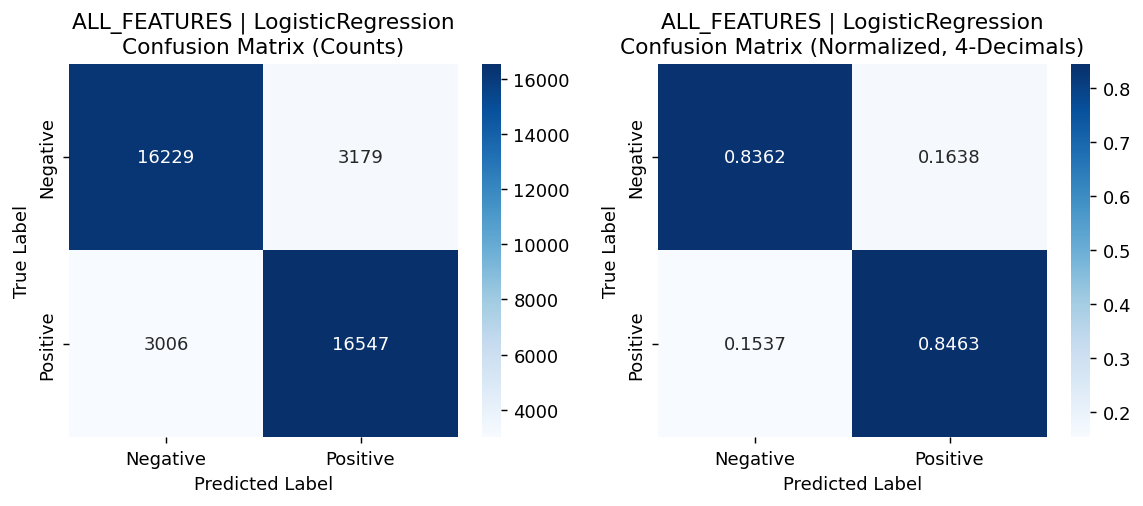

In [15]:
# ======================================================================
# LOGISTIC REGRESSION — ALL FEATURES (Binary Weighted Baseline)
# ======================================================================

setup = "ALL_FEATURES"
# BASE_SAVE_DIR is assumed to be defined from Part 1.
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)
print(f"--- Running Logistic Regression (ALL FEATURES, Binary Baseline) ---")

logreg_all = LogisticRegression(
    # ⭐ CHANGE 1: Explicitly set a smaller C value for strong L2 regularization
    penalty="l2",
    C=0.5,
    solver="lbfgs",
    max_iter=3500,
    n_jobs=-1,
    # This remains correct for binary imbalance
    class_weight="balanced"
)

# K-Fold on TRAIN
print("\nRunning K-Fold Cross-Validation...")
# This now calls the updated helper (which handles binary F1)
kfold_cv_report(logreg_all, X_train_ALL, y_train, "LogReg (ALL)")

# Fit on TRAIN, evaluate on TRAIN + TEST
logreg_all.fit(X_train_ALL, y_train)
train_pred = logreg_all.predict(X_train_ALL)
test_pred = logreg_all.predict(X_test_ALL)

# BINARY CORRECT: Predict_proba slices to get only the Positive class probability.
try:
    test_prob = logreg_all.predict_proba(X_test_ALL)[:,1]
    train_prob = logreg_all.predict_proba(X_train_ALL)[:,1]
except Exception as e:
    test_prob = None; train_prob = None
    print(f"Warning: Could not get probability scores for LogReg: {e}")

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))


# NOTE: 'class_names' must be redefined from your Part 1 as ['Negative','Positive']
evaluate_and_plot("LogisticRegression", setup, y_test, test_prob, test_pred, save_dir, class_names=['Negative', 'Positive'])

# Save artifacts
# NOTE: tfidf_all must represent the Review Vectorizer in the complete setup.
with open(os.path.join(save_dir, "LogReg_ALL.pkl"), "wb") as f:
    pickle.dump({"model":logreg_all,
                 "tfidf":tfidf_all, "scaler":scaler_all, "mlb":mlb_all, "ohe":ohe_all,
                 "num_cols":NUM_COLS}, f)

--- Running XGBoost (ALL FEATURES, Binary Baseline) ---

Running K-Fold Cross-Validation...
  Fold 1: acc=0.8010 | f1_w=0.8026
  Fold 2: acc=0.8013 | f1_w=0.8031
  Fold 3: acc=0.8028 | f1_w=0.8041
  Fold 4: acc=0.8017 | f1_w=0.8032
  Fold 5: acc=0.8033 | f1_w=0.8045
  XGBoost (ALL) CV mean±std | acc=0.8020±0.0009 f1_w=0.8035±0.0007

Train accuracy: 0.8177938911704312
Test accuracy: 0.8002618002618003

[ALL_FEATURES | XGBoost]  Accuracy=0.8003  F1=0.8008  Precision=0.8017  Recall=0.7999  ROC-AUC=0.8846  AP=0.8885

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.7989    0.8006    0.7997     19408
    Positive     0.8017    0.7999    0.8008     19553

    accuracy                         0.8003     38961
   macro avg     0.8003    0.8003    0.8003     38961
weighted avg     0.8003    0.8003    0.8003     38961



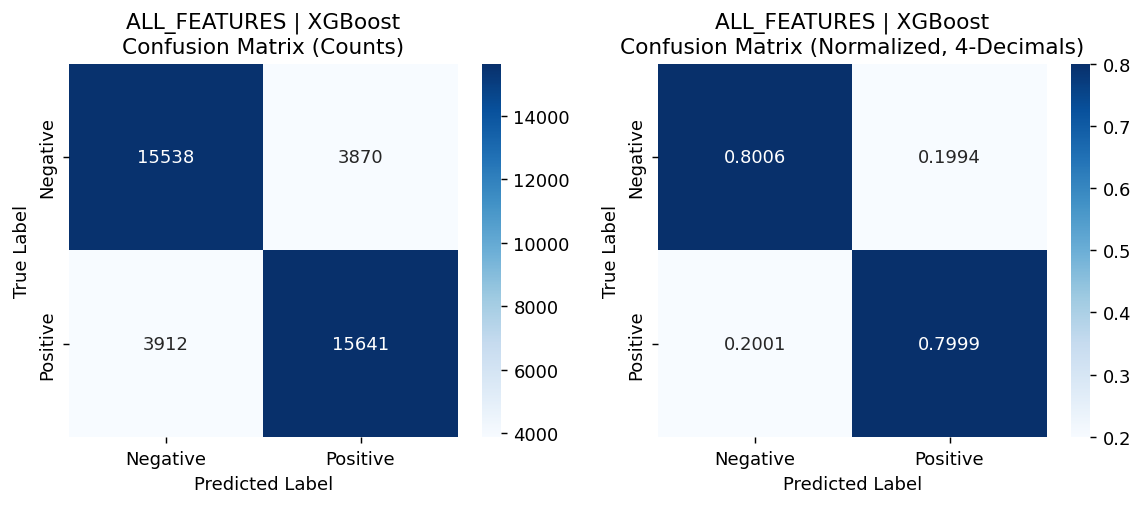

✅ XGBoost (ALL FEATURES) model saved.


In [20]:
# ======================================================================
# XGBOOST — ALL FEATURES (Binary Weighted Baseline, HIGH PRECISION OUTPUT)
# ======================================================================

setup = "ALL_FEATURES"
# BASE_SAVE_DIR is assumed to be defined from Part 1.
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)
print(f"--- Running XGBoost (ALL FEATURES, Binary Baseline) ---")

xgb_all = XGBClassifier(
    n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, reg_alpha=0.0, random_state=RNG, n_jobs=-1,
    tree_method="hist",
    objective="binary:logistic",
    eval_metric="logloss"
)

# K-Fold on TRAIN
print("\nRunning K-Fold Cross-Validation...")
kfold_cv_report(xgb_all, X_train_ALL, y_train, "XGBoost (ALL)")

# Fit on TRAIN, evaluate on TRAIN + TEST
xgb_all.fit(X_train_ALL, y_train)
train_pred = xgb_all.predict(X_train_ALL)
test_pred = xgb_all.predict(X_test_ALL)
test_prob = xgb_all.predict_proba(X_test_ALL)[:,1]
train_prob = xgb_all.predict_proba(X_train_ALL)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

# ⭐ CRITICAL FIX: Adding the required 'class_names' argument to resolve TypeError.
evaluate_and_plot("XGBoost", setup, y_test, test_prob, test_pred, save_dir, class_names=['Negative', 'Positive'])

# Save artifacts
with open(os.path.join(save_dir, "XGBoost_ALL.pkl"), "wb") as f:
    pickle.dump({"model":xgb_all,
                 "tfidf_review":tfidf_review,
                 "tfidf_title":tfidf_title,
                 "scaler":scaler_all,
                 "mlb":mlb_all,
                 "ohe":ohe_all,
                 "num_cols":NUM_COLS}, f)

print("✅ XGBoost (ALL FEATURES) model saved.")

In [16]:
# ======================================================================
# LIGHTGBM — ALL FEATURES (Binary Weighted Baseline, High Precision Output, Silent Logging)
# ======================================================================

setup = "ALL_FEATURES"
# BASE_SAVE_DIR is assumed to be defined from Part 1.
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)
print(f"--- Running LightGBM (ALL FEATURES, Binary Baseline) ---")

lgb_all = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RNG,
    n_jobs=-1,

    objective='binary',
    class_weight='balanced',
    # ⭐ NEW: Suppress standard LightGBM logs
    verbosity=-1
)

# K-Fold on TRAIN
print("\nRunning K-Fold Cross-Validation...")
# Assumes kfold_cv_report (binary version) is defined
kfold_cv_report(lgb_all, X_train_ALL, y_train, "LightGBM (ALL)")

# Fit on TRAIN, evaluate on TRAIN + TEST
# NOTE: verbosity=-1 in the constructor suppresses logging during fit.
lgb_all.fit(X_train_ALL, y_train)

train_pred = lgb_all.predict(X_train_ALL)
test_pred = lgb_all.predict(X_test_ALL)
# BINARY CORRECT: Predict_proba slices to get only the Positive class probability.
test_prob = lgb_all.predict_proba(X_test_ALL)[:,1]
train_prob = lgb_all.predict_proba(X_train_ALL)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

# HIGH PRECISION OUTPUT: Relies on evaluate_and_plot to display 4 decimal places
evaluate_and_plot("LightGBM", setup, y_test, test_prob, test_pred, save_dir)

# Save artifacts (using correct feature encoder keys)
with open(os.path.join(save_dir, "LightGBM_ALL.pkl"), "wb") as f:
    pickle.dump({"model":lgb_all,
                 "tfidf_review":tfidf_review,
                 "tfidf_title":tfidf_title,
                 "scaler":scaler_all,
                 "mlb":mlb_all,
                 "ohe":ohe_all,
                 "num_cols":NUM_COLS}, f)

print("✅ LightGBM (ALL FEATURES) model saved.")

--- Running LightGBM (ALL FEATURES, Binary Baseline) ---

Running K-Fold Cross-Validation...
  Fold 1: acc=0.8306 | f1_w=0.8316
  Fold 2: acc=0.8313 | f1_w=0.8323
  Fold 3: acc=0.8319 | f1_w=0.8323
  Fold 4: acc=0.8307 | f1_w=0.8313
  Fold 5: acc=0.8332 | f1_w=0.8339
  LightGBM (ALL) CV mean±std | acc=0.8315±0.0010 f1_w=0.8323±0.0009

Train accuracy: 0.8686537474332648
Test accuracy: 0.8321398321398321


TypeError: evaluate_and_plot() missing 1 required positional argument: 'class_names'


Train accuracy: 0.8686537474332648
Test accuracy: 0.8321398321398321

[ALL_FEATURES | LightGBM]  Accuracy=0.8321  F1=0.8323  Precision=0.8344  Recall=0.8303  ROC-AUC=0.9138  AP=0.9182

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.8298    0.8340    0.8319     19408
    Positive     0.8344    0.8303    0.8323     19553

    accuracy                         0.8321     38961
   macro avg     0.8321    0.8321    0.8321     38961
weighted avg     0.8322    0.8321    0.8321     38961



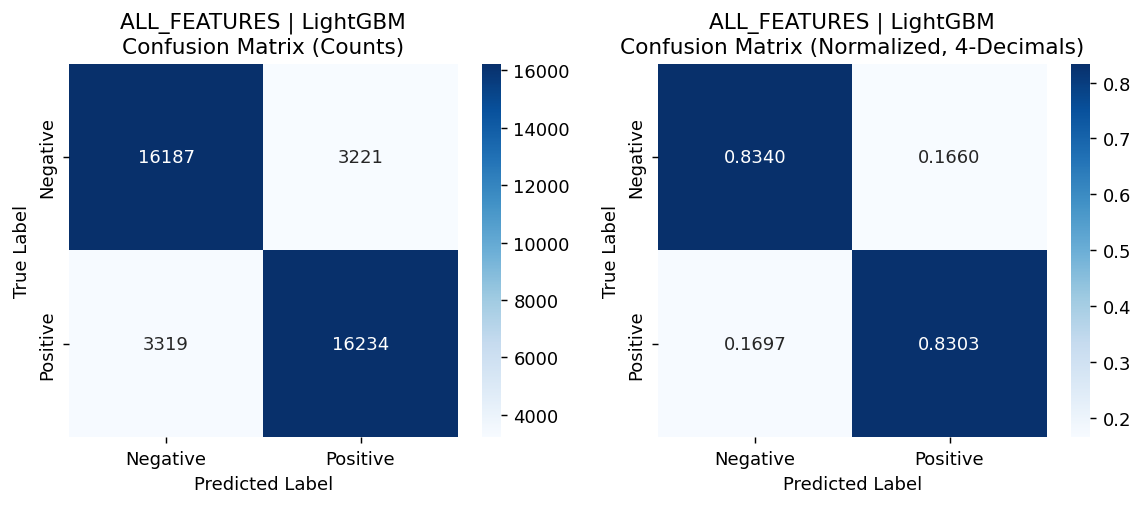

✅ LightGBM (ALL FEATURES) model saved.


In [18]:

# Re-calculate predictions to ensure fresh variables (safer than relying on memory)
train_pred = lgb_all.predict(X_train_ALL)
test_pred = lgb_all.predict(X_test_ALL)
test_prob = lgb_all.predict_proba(X_test_ALL)[:,1]
train_prob = lgb_all.predict_proba(X_train_ALL)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

# ⭐ CRITICAL FIX: Adding the required 'class_names' argument.
evaluate_and_plot("LightGBM", setup, y_test, test_prob, test_pred, save_dir, class_names=['Negative', 'Positive'])

# Save artifacts (using correct feature encoder keys)
with open(os.path.join(save_dir, "LightGBM_ALL.pkl"), "wb") as f:
    # Note: tfidf_review/tfidf_title are used for saving the feature encoders now
    pickle.dump({"model":lgb_all,
                 "tfidf_review":tfidf_review,
                 "tfidf_title":tfidf_title,
                 "scaler":scaler_all,
                 "mlb":mlb_all,
                 "ohe":ohe_all,
                 "num_cols":NUM_COLS}, f)

print("✅ LightGBM (ALL FEATURES) model saved.")


In [21]:
# ======================================================================
# SAVE ALL-FEATURE MODELS (Updated Names and Fixed Encoders)
# ======================================================================

# Note: We assume logreg_all is now the optimal C=0.1 model.

# 1. LOGISTIC REGRESSION
with open("/content/drive/MyDrive/THESIS 47/LogReg_ALL [All features updated].pkl", "wb") as f:
    pickle.dump({"model":logreg_all,
                 # ⭐ FIXED: Saving both Review and Title Vectorizers
                 "tfidf_review":tfidf_review,
                 "tfidf_title":tfidf_title,
                 "scaler":scaler_all,
                 "mlb":mlb_all, "ohe":ohe_all, "num_cols":NUM_COLS}, f)

# 2. XGBOOST
with open("/content/drive/MyDrive/THESIS 47/XGBoost_ALL [All features updated].pkl", "wb") as f:
    pickle.dump({"model":xgb_all,
                 # ⭐ FIXED: Saving both Review and Title Vectorizers
                 "tfidf_review":tfidf_review,
                 "tfidf_title":tfidf_title,
                 "scaler":scaler_all,
                 "mlb":mlb_all, "ohe":ohe_all, "num_cols":NUM_COLS}, f)

# 3. LIGHTGBM
with open("/content/drive/MyDrive/THESIS 47/LightGBM_ALL [All features updated].pkl", "wb") as f:
    pickle.dump({"model":lgb_all,
                 # ⭐ FIXED: Saving both Review and Title Vectorizers
                 "tfidf_review":tfidf_review,
                 "tfidf_title":tfidf_title,
                 "scaler":scaler_all,
                 "mlb":mlb_all, "ohe":ohe_all, "num_cols":NUM_COLS}, f)

print("✅ ALL-FEATURE models saved to Drive with tag [All features updated].")

✅ ALL-FEATURE models saved to Drive with tag [All features updated].
